# Understanding Su-scaled Rotary Position Embeddings (RoPE)

The Phi-3-Vision model leverages Su-scaled RoPE, a variant of Rotary Position Embeddings, to effectively extend its context length to an impressive 128K tokens, enabling it to process and reason over longer sequences of text and visual information.

```python
class Phi3SuScaledRotaryEmbedding(nn.Module):
    def __init__(self, dim, config):
        self.dim = dim
        self.base = config.rope_theta
        self.short_factor = config.rope_scaling["short_factor"]
        self.long_factor = config.rope_scaling["long_factor"]
        self.original_max_position_embeddings = config.original_max_position_embeddings
        self.scaling_factor = math.sqrt(1 + math.log(config.max_position_embeddings / config.original_max_position_embeddings) / math.log(config.original_max_position_embeddings))
        self.inv_freq = None

    def __call__(self, position_ids):
        seq_len = position_ids.max() + 1
        ext_factors = mx.array(self.long_factor, dtype=mx.float32) if seq_len > self.original_max_position_embeddings else mx.array(self.short_factor, dtype=mx.float32)
        inv_freq_shape = mx.arange(0, self.dim, 2, dtype=mx.float32) / self.dim
        self.inv_freq = 1.0 / (ext_factors * self.base**inv_freq_shape)
        inv_freq_expanded = mx.repeat(self.inv_freq[None, :, None], position_ids.shape[0], axis=0)
        position_ids_expanded = mx.array(position_ids, dtype=mx.float32)[:, None, :]
        freqs = mx.matmul(inv_freq_expanded, position_ids_expanded).transpose(0, 2, 1)  
        emb = mx.concatenate([freqs, freqs], axis=-1)  
        cos = mx.cos(emb) * self.scaling_factor
        sin = mx.sin(emb) * self.scaling_factor
        return cos, sin
```

## 1. Inverse Frequencies

- Each frequency is associated with a specific dimension in the embedding space.

## 2. Position IDs:

- Each token in the sequence is assigned a unique position ID (0, 1, 2, etc.).

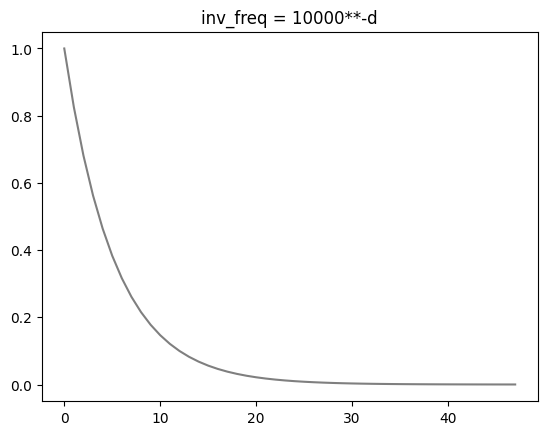

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

position_ids= np.arange(15)[None]
dim = 3072/32 # = hidden_size / num_heads
inv_freq_shape = np.arange(0, dim, 2) / dim
inv_freq_vanilla = 1.0 / (10000.0**inv_freq_shape)

inv_freq = inv_freq_vanilla

plt.figure()
plt.title('inv_freq = 10000**-d')
plt.plot(inv_freq, c='k', alpha = 0.5, label = 'None')

## 3. Frequency-Position Interaction:

- The inverse frequencies are multiplied by the position IDs, creating unique sinusoidal patterns for each position.
These patterns are interleaved to produce two separate vectors: one for the sine component and one for the cosine component.
These vectors are then added to the original input embeddings.

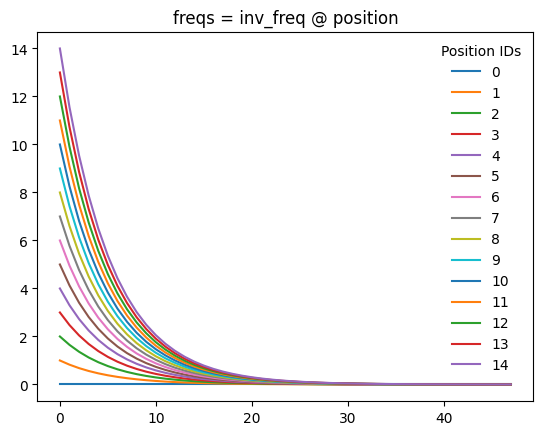

In [3]:
inv_freq_expanded = np.repeat(inv_freq[None, :, None], position_ids.shape[0], axis=0)
position_ids_expanded = position_ids[:, None, :]
freqs = np.matmul(inv_freq_expanded, position_ids_expanded).transpose(0, 2, 1)  # (1,15,48)

plt.figure()
plt.title('freqs = inv_freq @ position')
for i, freq_i in enumerate(freqs[0]):
  plt.plot(freq_i.flatten(), label = i)
plt.legend(title="Position IDs", loc="upper right", frameon=False, fontsize=10)

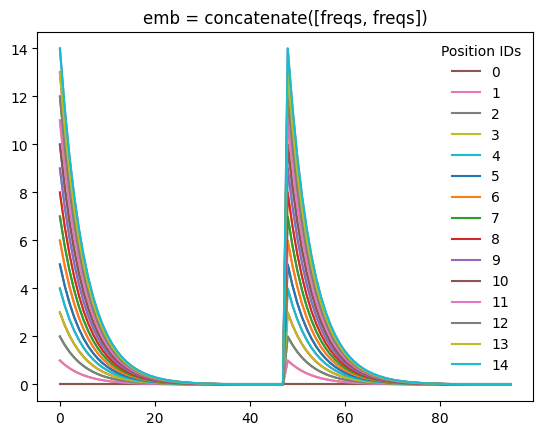

In [4]:
emb = np.concatenate([freqs, freqs], axis=-1)
plt.figure()
plt.title('emb = concatenate([freqs, freqs])')
for i in emb[0]:
  plt.plot(i.flatten())
for i, emb_i in enumerate(emb[0]):
  plt.plot(emb_i.flatten(), label = i)
plt.legend(title="Position IDs", loc="upper right", frameon=False, fontsize=10)

Imagine each frequency as a wave with a different wavelength.  Lower frequencies have longer wavelengths and capture broader patterns, while higher frequencies have shorter wavelengths and capture finer details. By combining these waves with the position IDs, you get unique patterns that the model can learn to interpret as positional information.

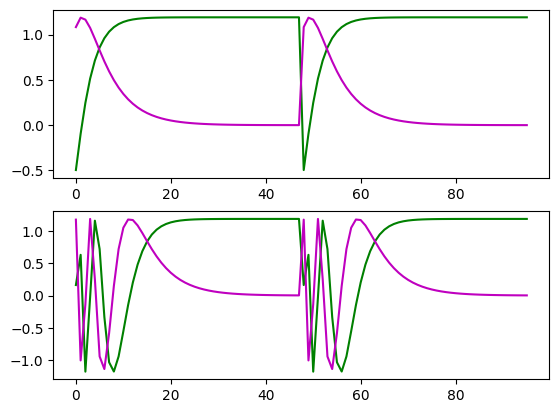

In [5]:
scaling_factor = 1.1902380714238083 # math.sqrt(1 + math.log(max_position_embeddings / original_max_position_embeddings) / math.log(original_max_position_embeddings)) where max_position_embeddings, original_max_position_embeddings = 131072, 4096
cos = np.cos(emb) * scaling_factor # (1, 15, 96)
sin = np.sin(emb) * scaling_factor
plt.figure()
plt.subplot(211)
plt.plot(cos[0][2], c='g')
plt.plot(sin[0][2], c='m')
plt.subplot(212)
plt.plot(cos[0][-1], c='g')
plt.plot(sin[0][-1], c='m')

## 4. Su-scaled RoPE:

In Su-scaled RoPE, the base inverse frequencies are multiplied by scaling factors.
These scaling factors are designed to adjust the frequencies based on the sequence length, allowing the model to better handle both short and long sequences.


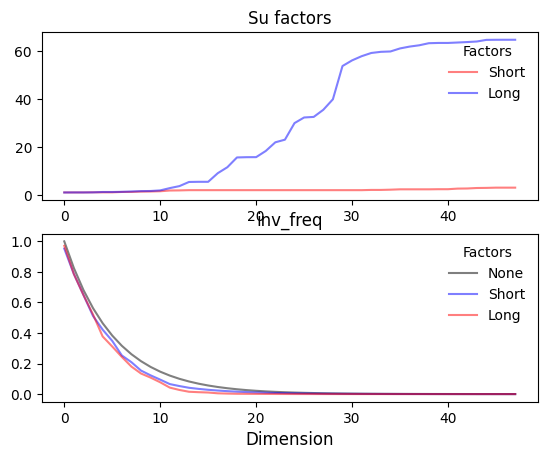

In [6]:
short_factors = np.array([1.05, 1.05, 1.05, 1.1, 1.1, 1.1, 1.2500000000000002, 1.2500000000000002, 1.4000000000000004, 1.4500000000000004, 1.5500000000000005, 1.8500000000000008, 1.9000000000000008, 2.000000000000001, 2.000000000000001, 2.000000000000001, 2.000000000000001, 2.000000000000001, 2.000000000000001, 2.000000000000001, 2.000000000000001, 2.000000000000001, 2.000000000000001, 2.000000000000001, 2.000000000000001, 2.000000000000001, 2.000000000000001, 2.000000000000001, 2.000000000000001, 2.000000000000001, 2.000000000000001, 2.000000000000001, 2.1000000000000005, 2.1000000000000005, 2.2, 2.3499999999999996, 2.3499999999999996, 2.3499999999999996, 2.3499999999999996, 2.3999999999999995, 2.3999999999999995, 2.6499999999999986, 2.6999999999999984, 2.8999999999999977, 2.9499999999999975, 3.049999999999997, 3.049999999999997, 3.049999999999997 ])
long_factors = np.array([ 1.0299999713897705, 1.0499999523162842, 1.0499999523162842, 1.0799999237060547, 1.2299998998641968, 1.2299998998641968, 1.2999999523162842, 1.4499999284744263, 1.5999999046325684, 1.6499998569488525, 1.8999998569488525, 2.859999895095825, 3.68999981880188, 5.419999599456787, 5.489999771118164, 5.489999771118164, 9.09000015258789, 11.579999923706055, 15.65999984741211, 15.769999504089355, 15.789999961853027, 18.360000610351562, 21.989999771118164, 23.079999923706055, 30.009998321533203, 32.35000228881836, 32.590003967285156, 35.56000518798828, 39.95000457763672, 53.840003967285156, 56.20000457763672, 57.95000457763672, 59.29000473022461, 59.77000427246094, 59.920005798339844, 61.190006256103516, 61.96000671386719, 62.50000762939453, 63.3700065612793, 63.48000717163086, 63.48000717163086, 63.66000747680664, 63.850006103515625, 64.08000946044922, 64.760009765625, 64.80001068115234, 64.81001281738281, 64.81001281738281 ])

plt.figure()
plt.subplot(211)
plt.title('Su factors')
plt.plot(short_factors, c = 'r', alpha = 0.5, label = 'Short')
plt.plot(long_factors, c = 'b', alpha = 0.5, label = 'Long')
plt.legend(title="Factors", loc="upper right", frameon=False, fontsize=10)

inv_freq_short = 1.0 / (short_factors * 10000.0**inv_freq_shape)
inv_freq_long = 1.0 / (long_factors * 10000.0**inv_freq_shape)

plt.subplot(212)
plt.title('inv_freq')
plt.plot(inv_freq_vanilla, c='k', alpha = 0.5, label = 'None')
plt.plot(inv_freq_short, c='b', alpha = 0.5, label = 'Short')
plt.plot(inv_freq_long, c='r', alpha = 0.5, label = 'Long')
plt.xlabel('Dimension', fontsize=12)
plt.legend(title="Factors", loc="upper right", frameon=False, fontsize=10)

### 4.1 Short factor scaled RoPE

<ipython-input-7-4f7465b2260c>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(211)


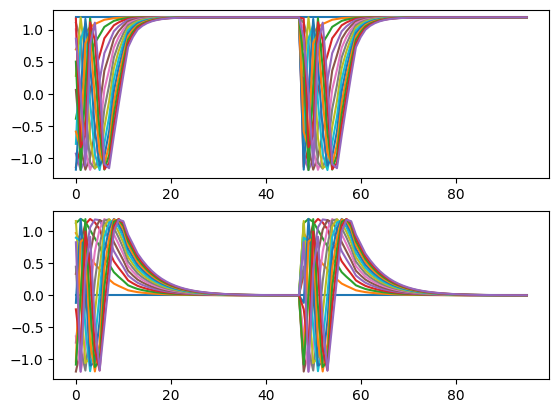

In [7]:
inv_freq = inv_freq_short

inv_freq_expanded = np.repeat(inv_freq[None, :, None], position_ids.shape[0], axis=0)
position_ids_expanded = position_ids[:, None, :]
freqs = np.matmul(inv_freq_expanded, position_ids_expanded).transpose(0, 2, 1)  # (1,15,48)
emb = np.concatenate([freqs, freqs], axis=-1)
scaling_factor = 1.1902380714238083 # math.sqrt(1 + math.log(max_position_embeddings / original_max_position_embeddings) / math.log(original_max_position_embeddings)) where max_position_embeddings, original_max_position_embeddings = 131072, 4096
cos = np.cos(emb) * scaling_factor # (1, 15, 96)
plt.figure()
plt.title('sin, cos')
plt.subplot(211)
for i in cos[0]:
  plt.plot(i.flatten())
sin = np.sin(emb) * scaling_factor
plt.subplot(212)
for i in sin[0]:
  plt.plot(i.flatten())

### 4.2 Long factor scaled RoPE

<ipython-input-8-4391cbc3eff3>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(211)


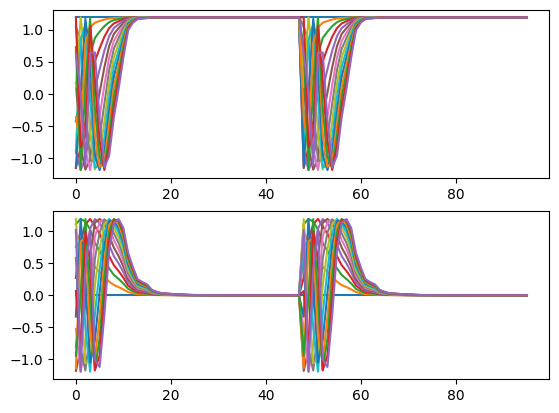

In [8]:
inv_freq = inv_freq_long

inv_freq_expanded = np.repeat(inv_freq[None, :, None], position_ids.shape[0], axis=0)
position_ids_expanded = position_ids[:, None, :]
freqs = np.matmul(inv_freq_expanded, position_ids_expanded).transpose(0, 2, 1)  # (1,15,48)
emb = np.concatenate([freqs, freqs], axis=-1)
scaling_factor = 1.1902380714238083 # math.sqrt(1 + math.log(max_position_embeddings / original_max_position_embeddings) / math.log(original_max_position_embeddings)) where max_position_embeddings, original_max_position_embeddings = 131072, 4096
cos = np.cos(emb) * scaling_factor # (1, 15, 96)
plt.figure()
plt.title('sin, cos')
plt.subplot(211)
for i in cos[0]:
  plt.plot(i.flatten())
sin = np.sin(emb) * scaling_factor
plt.subplot(212)
for i in sin[0]:
  plt.plot(i.flatten())